# Classical Time Series (TS) Forecasting


## Overview
Theory and implementation in python:
- How to create a Time Series forecast
- Dickey-Fuller test & ARIMA (Autoregressive, moving average) models

TS is a collection of data points collected at **constant time intervals**. <br>
The analysis tries to determine the long term trend in order to forecast the future. <br>
Important differences of TS from other datasets are:
1. It is **time dependent**. The basic assumption of a linear regression model (the observations are independent) doesn’t hold in this case.
2. Most TS have some form of **seasonality trends**.
<br><br>

Classical time series forecasting methods focus on linear relationships but they are sophisticated and perform well on a wide range of problems as long as the data is suitably prepared and the method has been configured properly.

The main points of this analysis are:
1. **Data Preparation**
    1. Check TS Stationality
    2. Making a TS Stationary
        * Trend estimation and elimination
        * Trend and seasonality (Differentiation and Decomposition)
2. **Classical Forecasting Methods**
    * Autoregression (AR)
    * Moving Average (MA)
    * Autoregressive Moving Average (ARMA)
    * Autoregressive Integrated Moving Average (ARIMA)
    * Seasonal Autoregressive Integrated Moving-Average (SARIMA)
    * Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
    * Vector Autoregression (VAR)
    * Vector Autoregression Moving-Average (VARMA)
    * Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
    * Simple Exponential Smoothing (SES)
    * Holt Winter’s Exponential Smoothing (HWES)

### Load Basic Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import os
import sys
import re
from tqdm import tqdm
import yaml
import watermark
from math import floor
from pprint import pprint as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling
sys.path.append(os.pardir)

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 251022fb48475d9b10feccdb93dc36d49977d62a


### Constants

In [2]:
INPUT_DATA = "../data/raw/air_passengers.csv"
OUTPUT_FOLDER = "../data/processed/"
MODELS_FOLDER = "../models/"
FIGURES_FOLDER = "../data/fig/"

### Load Data

The first step is to load the data to explore and evaluate the characteristics of the dataset. Structure, format, statistics of the data, distribution, etc.

In [3]:
passengers_df = pd.read_csv(INPUT_DATA)

In [4]:
passengers_df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
passengers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month         144 non-null object
Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


The data contains month and number of passengers travelling in that month. This has not been read as a TS object as the data types are ‘object’ and ‘int’. To ensure that it is read as TS we have to define some special arguments that will ensure that the column of dates is parsed properly and used as index of the dataset:

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
passengers_df = pd.read_csv(
    INPUT_DATA, 
    parse_dates=['Month'],    # specifies the column which contains the date-time information
    date_parser=dateparse,    # Specifies a function which converts an input string into datetime variable.
    index_col='Month')        # When using Pandas for TS data the index has to be the variable depicting 
                              #      date-time information

# Note: default date_parser is ‘YYYY-MM-DD HH:MM:SS’

passengers_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [7]:
passengers_df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
passengers_df.profile_report()

In [9]:
passengers_df.index[:10]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

Note that despite having monthly data pandas has not been able to identify the frequency of the data. We can correct that by re-constructing the index and using the inferred frequency.

In [10]:
# Infer the frequency for the TS from the data
passengers_df.index = pd.DatetimeIndex(passengers_df.index.values, freq=passengers_df.index.inferred_freq)

In [11]:
passengers_df.index[:10]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01'],
              dtype='datetime64[ns]', freq='MS')

#### TS Indexing

Now as espected the dtype is datetime64[ns] <br>
To retrieve a value we can do it in two ways:
* &nbsp;&nbsp; passengers_df['1955-12-01']
* &nbsp;&nbsp; passengers_df[datetime(1955,12,1)]
<br><br>

And the same when retrieving a range. The difference vs numeric indexing is the the range will include the end of the range specified and the two following requests will have the same output:
* &nbsp;&nbsp; passengers_df['1955-01-01':'1955-12-01']
* &nbsp;&nbsp; passengers_df['1955']  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  # Omitting the month retrieves all 1955 data

## 1. Data Preparation

### A) Check TS Stationarity

A TS is stationary if its statistical properties such as mean, variance, etc remain constant over time. This is important because most of the TS models work on the assumption that the TS is stationary. Intuitively we can see that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same behaviour in the future. On the other hand theories of stationary series are more mature and easier to implement compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie:

1. constant mean
2. constant variance
3. autocovariance that does not depend on time.

To test stationarity let's first have a look to the data.

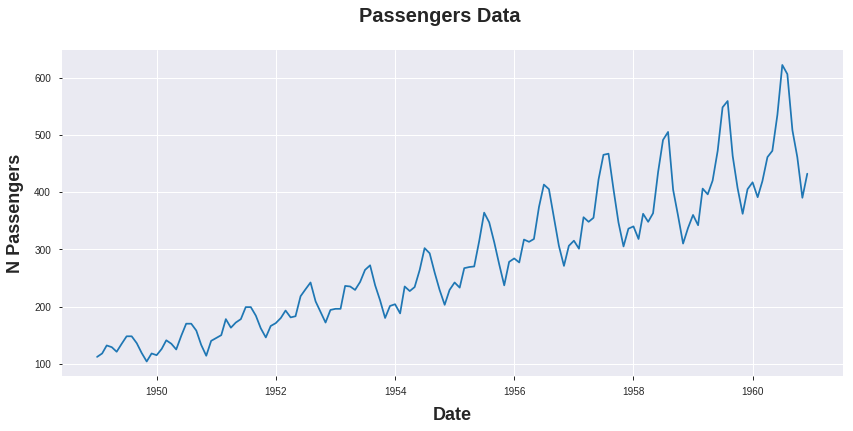

In [12]:
ps = passengers_df["Passengers"]
window = 12           # Use 12 months for the windowing

plt.plot(ps)
fig = plt.gcf()
fig.set_size_inches(14, 6)
fig.suptitle('Passengers Data', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=18, weight='bold', labelpad=10)
plt.ylabel('N Passengers', fontsize=18, weight='bold', labelpad=10)
fig.savefig(os.path.join(FIGURES_FOLDER, 'passengers.png'), dpi=100)

In this case we have a clear **overall increasing trend** with seasonal variations. But it is not always possible to do this visually. In such cases we use:

1. **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time (ie the average/variance of last 12 months).
2. **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results include a ‘Test Statistic’ and Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    fig = plt.gcf()
    fig.set_size_inches(14, 6)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

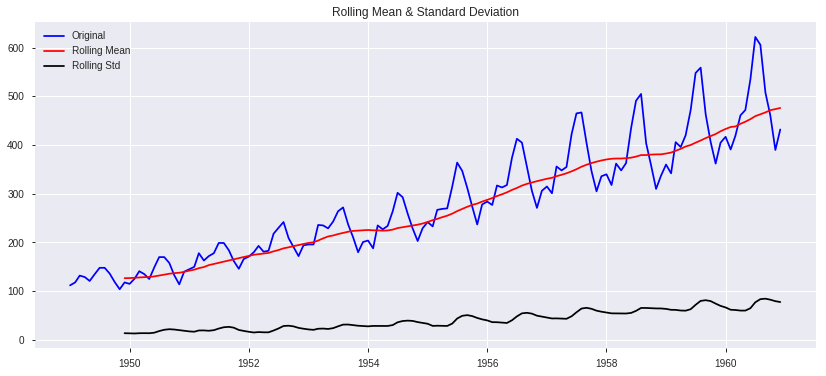

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(ps)

Our dataset has a clear increase with time in the mean although the variation in standard deviation is small so this is not a stationary serie. Also the test statistic is way more than the critical values. Note that the signed values should be compared and not just the absolute values.


### B) Making a TS Stationary

Though stationarity assumption is taken in many TS models almost none of practical TS are stationary. Because of that statisticians have figured out ways to transform series to something close to stationary (it's almost impossible to make a series perfectly stationary).

First let's analyse what makes a TS non-stationary:
1. Trend: varying mean over time.
2. Seasonality: variations at specific time-frames.

The principle is to model or estimate the trend and seasonality in the series and remove those factors from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### B1) Estimating & Eliminating Trend

One possible method to reduce trend is **transformation**. The transformation will penalize higher values over time more than recent smaller values. Examples of this transformation can be ***log, square root, cube root, etc.***

In order to have a more clear estimate, we may want to eliminate or reduce the noise. This can be achieved easily with one of the following techniques:
* **Agreggation**: average over a time period 
* **Smoothing**: rolling averages
* **Polynomial Fitting**: fit a regression model

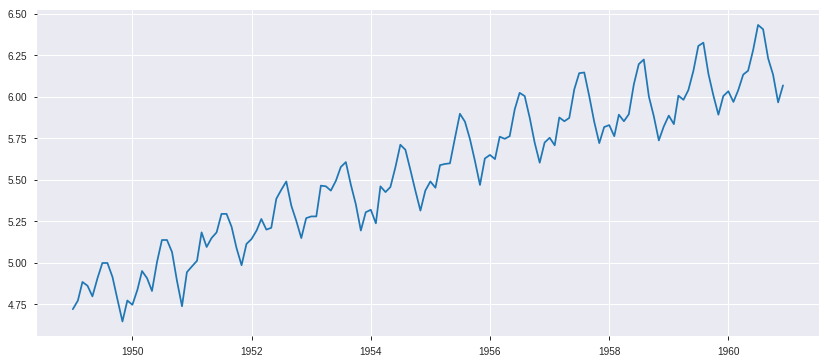

In [15]:
# Applying a transformation to reduce high values over time
ps_log = np.log(ps)
plt.plot(ps_log)
fig = plt.gcf(); fig.set_size_inches(14, 6);

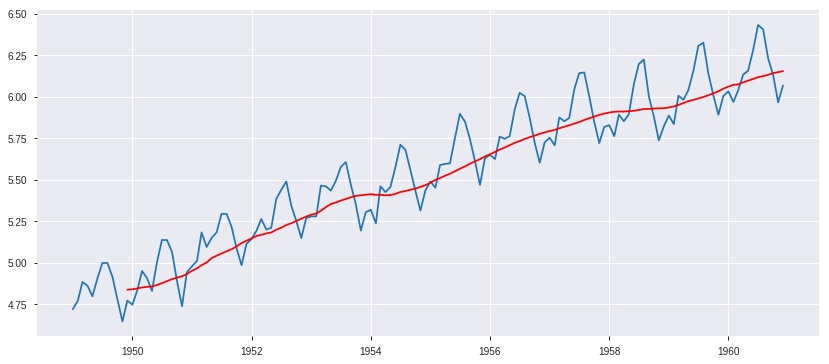

In [16]:
# Moving average with a window of 12 months
moving_avg = ps_log.rolling(window).mean()
plt.plot(ps_log)
plt.plot(moving_avg, color='red')
fig = plt.gcf(); fig.set_size_inches(14, 6);

In [17]:
# Remove the trend from the TS
ps_log_no_trend = ps_log - moving_avg
# Drop the nan values (the first 12 values don't have moving average to calculate the difference)
ps_log_no_trend.dropna(inplace=True)
ps_log_no_trend.shape

(133,)

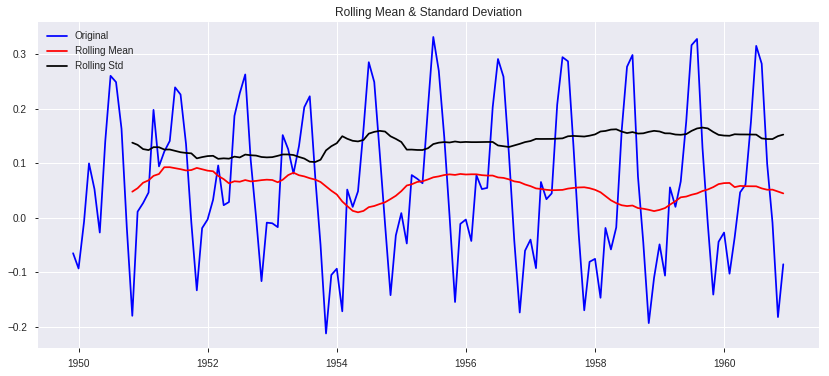

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
test_stationarity(ps_log_no_trend)

Now the TS appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

However a drawback in this approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to define a period. So we take a *‘weighted moving average’* where more recent values are given a higher weight. There are many techniques for applying weights from which a popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

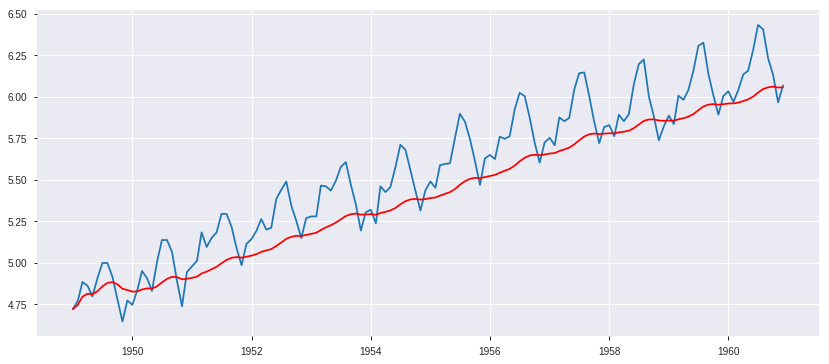

In [19]:
# Example of the exponentially weighted moving average
# halflife define the exponential decay 
exp_w_avg = ps_log.ewm(halflife=window).mean()
plt.plot(ps_log)
plt.plot(exp_w_avg, color='red')
fig = plt.gcf(); fig.set_size_inches(14, 6);

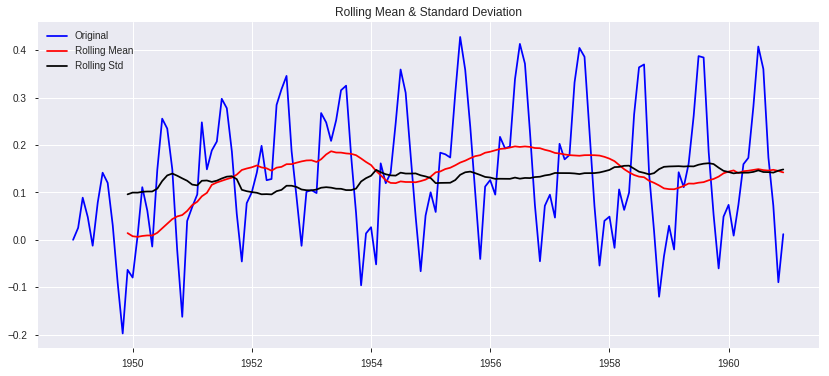

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ps_log_ewma_diff = ps_log - exp_w_avg
test_stationarity(ps_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also the test statistic is smaller than the 1% critical value which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights.

### B2) Eliminating Trend and Seasonality

The previous simple trend reduction techniques don’t work in all cases, particularly when we find high seasonality. Let's discuss two ways of removing trend and seasonality:

* **Differenciation**: apply the differece with a specific time lag
* **Decomposition**: modeling both trend and seasonality and removing them from the model.

####  Differenciation
This is a very common method to deal with both trend and seasonality. In this technique we take the difference of the observation at a particular instant with the previous instant. This mostly works well in improving stationarity. In pandas the previous instand can be retrieved using *shift()*

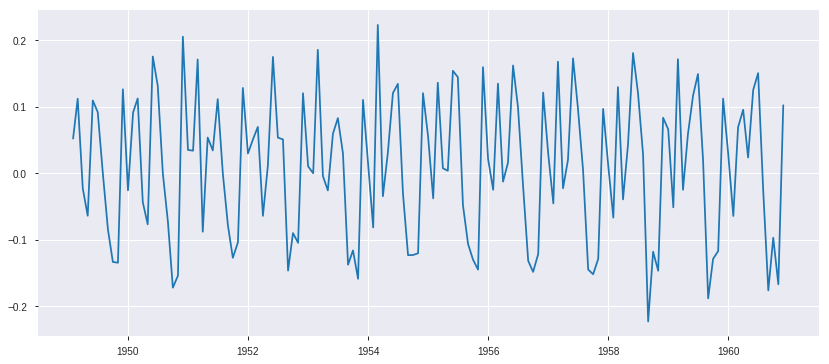

In [21]:
ps_log_diff = ps_log - ps_log.shift()
plt.plot(ps_log_diff)
fig = plt.gcf(); fig.set_size_inches(14, 6);

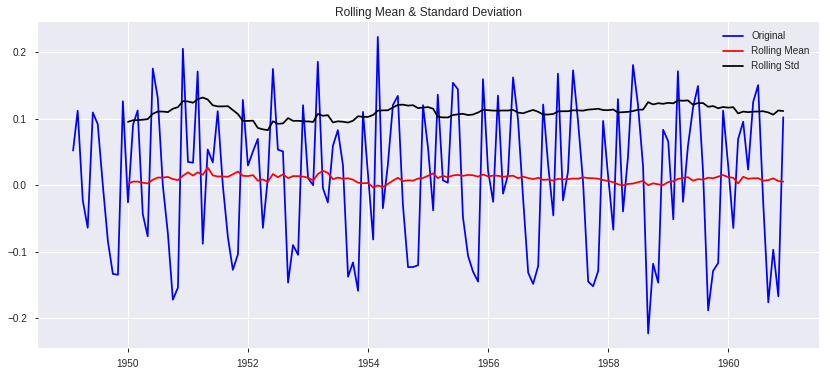

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
ps_log_diff.dropna(inplace=True)
test_stationarity(ps_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

#### Decomposition

Both trend and seasonality are modeled separately and the remaining part of the series is returned.

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ps_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

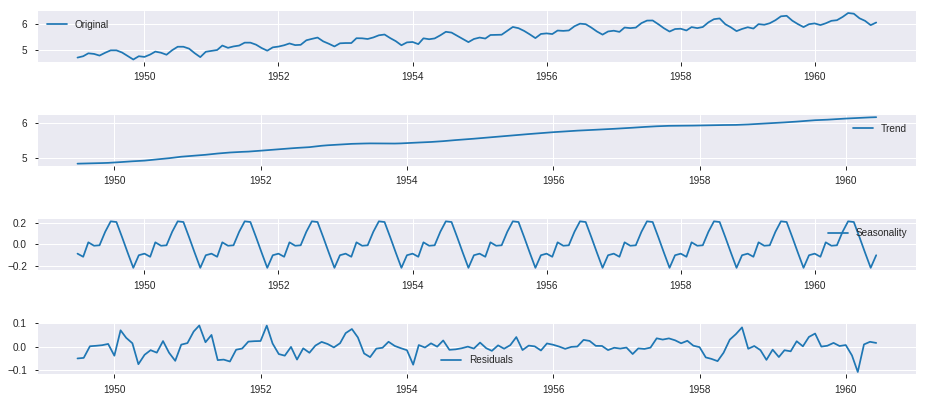

In [24]:
plt.subplot(411); plt.plot(ps_log, label='Original'); plt.legend(loc='best')
plt.subplot(412); plt.plot(trend, label='Trend'); plt.legend(loc='best')
plt.subplot(413); plt.plot(seasonal,label='Seasonality'); plt.legend(loc='best')
plt.subplot(414); plt.plot(residual, label='Residuals'); plt.legend(loc='best')
plt.tight_layout(); fig = plt.gcf(); fig.set_size_inches(14, 6);

We can see that trend and seasonality are separated out from the data and we can model the residuals. <br>
First let's check stationarity of residuals:

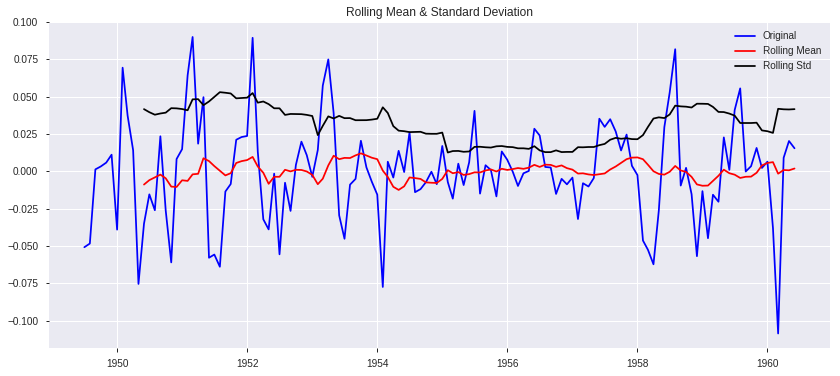

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [25]:
ps_log_decompose = residual
ps_log_decompose.dropna(inplace=True)
test_stationarity(ps_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also you should note that converting the residuals into original values for future data in not very intuitive in this case.

## 2. Forecasting

From all the different techniques let's use differencing as it is a very popular technique. It is relatively easier to add noise and seasonality back into predicted residuals in this case. After the trend and seasonality estimation techniques, there can be two situations:
1. A strictly stationary series with no dependence among values. It's the easy case, where we can model the residuals as white noise. *This is very rare*.
2. A series with significant dependence among values. In this case we need to use some statistical models like **ARIMA** to forecast the data.
<br><br>

### Autoregression (AR)

The autoregression method models the next step in the sequence as a linear function of the observations at prior time steps. The predictors depend on the parameter (p) of the AR model which specifies the order. For example AR(1) is a first-order autoregression model.

We can predict for example the value at the next time step (t+1) given the observations at the last two time steps (t-1 and t-2) as a regression model which because it uses data from the same input variable at previous time steps, it is referred to as an autoregression:

\begin{equation*}
X_{t+1}  ​​​= ​​​b_{0} ​​​+​​​ b_{1} ​​​\times ​​​X_{t-1} ​​​+​​​ b_{2} ​​​\times ​​​X_{t-2}       
\end{equation*}

The assumption is that the observations at previous time steps are useful to predict the value at the next time step and this relationship between variables is called correlation. If both variables change in the same direction (ex. go up together or down together) is called a positive correlation. If the variables move in opposite directions as values change then it is called negative correlation.

The correlation statistics can help to choose which lag variables will be useful in a model and which will not.

On top of that if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable.

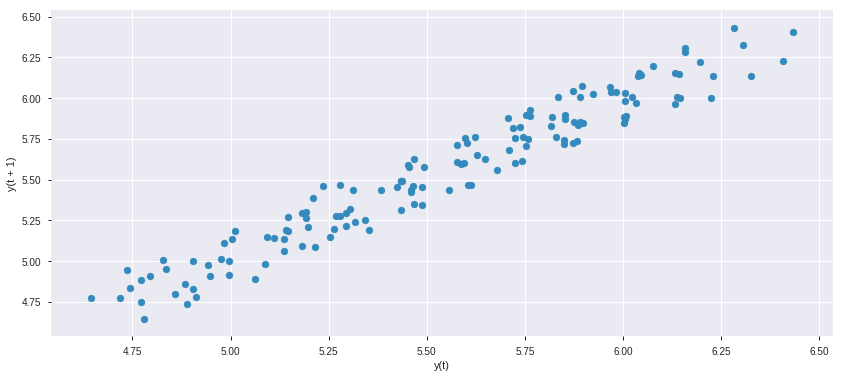

In [26]:
from pandas.plotting import lag_plot

lag_plot(ps_log, lag=1)
fig = plt.gcf(); fig.set_size_inches(14, 6);

In this case the scatter plot shows a clear positive correlation but this is mostly due to the trend of the data since we have use the passenger data with the log transformation applied to reduce the trend. Later we will analyse the residuals to verify is there is any autocorrelation in the residuals. We could try to use different lags as well...

Another quick check is to directly calculate the correlation between the observation and the lag variable using a statistical test like the Pearson correlation coefficient. This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation. Correlation can be calculated using the **corr()** function within pandas and we can choose different methods for its calculation:

In [27]:
from math import exp
from pandas import concat
from matplotlib import pyplot

ps_check = ps_log.copy()
ps_check = pd.concat([ps_check.shift(1), ps_check], axis=1)
ps_check.columns = ['t-1', 't+1']
result = ps_check.corr()
print("Pearson Correlation between t-1 and t+1:\n{}".format(result))

Pearson Correlation between t-1 and t+1:
          t-1       t+1
t-1  1.000000  0.970591
t+1  0.970591  1.000000


In [28]:
result = ps_check.corr(method='spearman')
print("Spearman Correlation between t-1 and t+1:\n{}".format(result))

Spearman Correlation between t-1 and t+1:
          t-1       t+1
t-1  1.000000  0.970081
t+1  0.970081  1.000000


To verify the correlation across multiple lags in order to have a better idea of how the correlation changes over time we can use the **autocorrelation_plot()**.

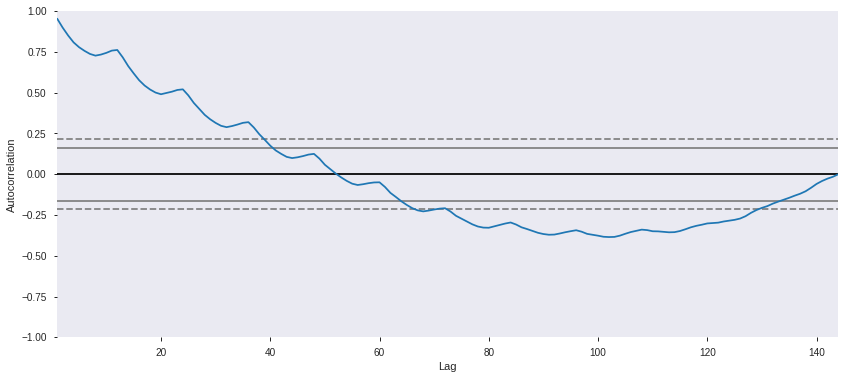

In [29]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ps_log)
fig = plt.gcf(); fig.set_size_inches(14, 6);

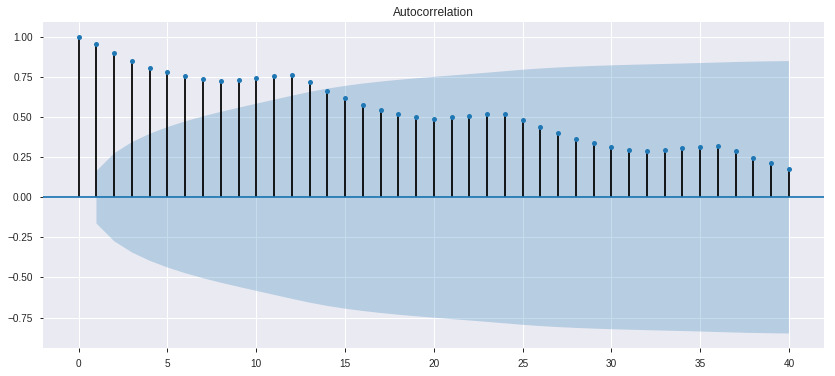

In [30]:
# Or using the statsmodels library
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ps_log, lags=40);
fig = plt.gcf(); fig.set_size_inches(14, 6);

As mentioned before let's analyse now the residuals and its autocorrelation.

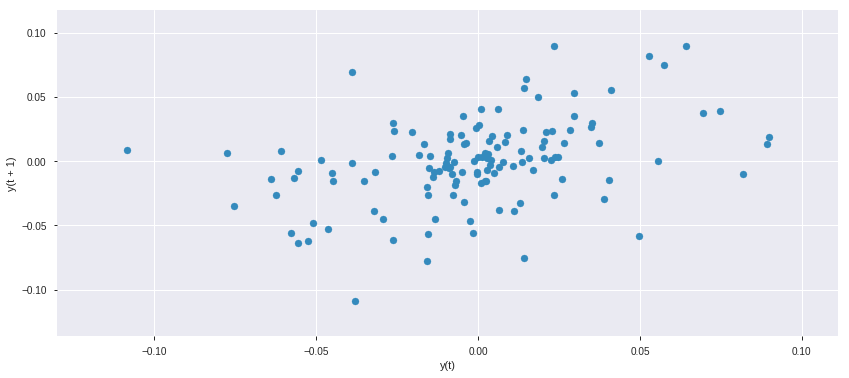

In [31]:
lag_plot(ps_log_decompose, lag=1)
fig = plt.gcf(); fig.set_size_inches(14, 6);

In this case the autocorrelation is much lower as we can verify again with the Pearson coefficient:

In [32]:
ps_check = ps_log_decompose.copy()
ps_check = pd.concat([ps_check.shift(1), ps_check], axis=1)
ps_check.columns = ['t-1', 't+1']
result = ps_check.corr()
print("Pearson Correlation between t-1 and t+1:\n{}".format(result))

Pearson Correlation between t-1 and t+1:
          t-1       t+1
t-1  1.000000  0.402683
t+1  0.402683  1.000000


The **Autoregression Model** of the statsmodels library selects automatically an appropriate lag value using statistical tests and trains a linear regression model. Once fitted we can use the predict() function to get a number of predictions in the future.

Model Lag: 13
Model Coefficients: 
[ 0.02413232 -0.38871835 -0.24506515 -0.16183881 -0.24492368 -0.11011312
 -0.2211594  -0.17559408 -0.27920605 -0.12137966 -0.23848827 -0.10946172
  0.66639831  0.30557055]


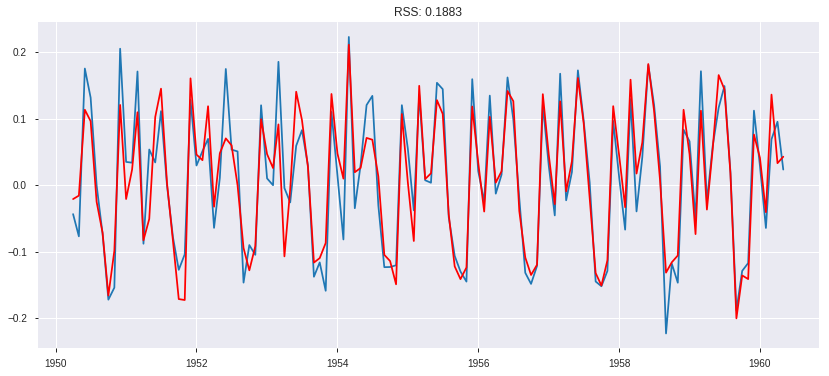

In [33]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

X = ps_log_diff
train, test = X[1:len(X)-7], X[len(X)-7:]

model_AR = AR(train.values)
results_AR = model_AR.fit()

n_fitted_diff = len(train) - len(results_AR.fittedvalues)
plt.plot(train[n_fitted_diff:])
fittedvalues = pd.Series(results_AR.fittedvalues, index=train.index[n_fitted_diff:])

plt.plot(fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((fittedvalues - train[n_fitted_diff:])**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);
print("Model Lag: %s" % results_AR.k_ar)
print("Model Coefficients: \n%s" % results_AR.params)

We can observe that a 13-lag model was selected as optimal and its coefficients selected which is interesting as it is the number of months of a year plus the constant of the linear regression equation.

Finally we can calculate the predictions of the values that we kept in the test set.

predicted=0.122213 	 expected=0.125288
predicted=0.145651 	 expected=0.150673
predicted=0.004964 	 expected=-0.026060
predicted=-0.152769 	 expected=-0.176399
predicted=-0.150069 	 expected=-0.097083
predicted=-0.100238 	 expected=-0.167251
predicted=0.092260 	 expected=0.102279
Test MSE: 0.001


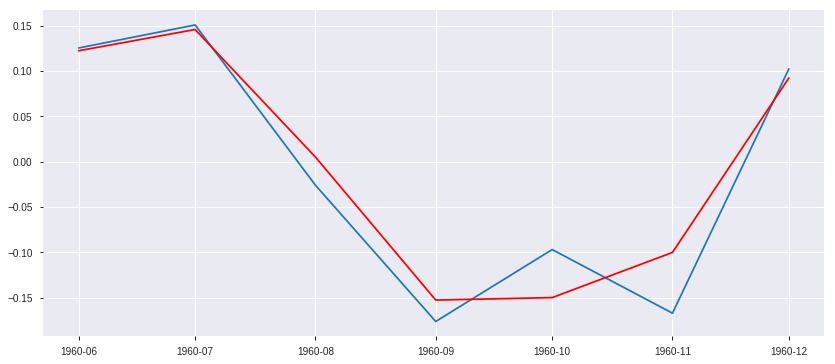

In [34]:
predictions = results_AR.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f \t expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
pred_series = pd.Series(predictions, index=test.index)
plt.plot(pred_series, color='red')
fig = plt.gcf(); fig.set_size_inches(14, 6);

If we want the original serie we have to undo the differentiation and the log

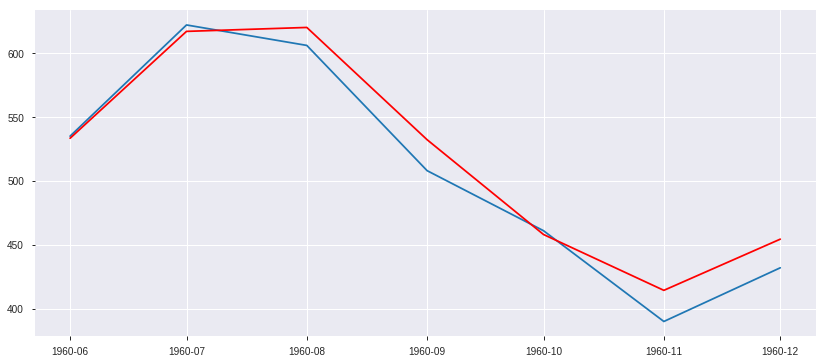

In [35]:
pred = pd.Series(ps_log.iloc[-8], index=ps_log.index[-7:])
pred = pred.add(predictions.cumsum(), fill_value=0).apply(exp)
passengers_test = passengers_df.tail(7)

plt.plot(passengers_test)
plt.plot(pred, color='red')
fig = plt.gcf(); fig.set_size_inches(14, 6);

It is easy to observe that the predictions follow the test data that we didn't use during the training.

### Moving Average (MA)

The MA model forecasts the next step in the sequence as a linear function of the residual erros from the mean process of previous time steps. This is different from the moving average of the time series. As in the previous model the MA have a parameter (q) that specifies the order of the model, xe MA(1) is the first-order moving average model.

Model Lag: 2
Model Coefficients: 
const               0.009995
ma.L1.Passengers   -0.146359
ma.L2.Passengers   -0.787750
dtype: float64


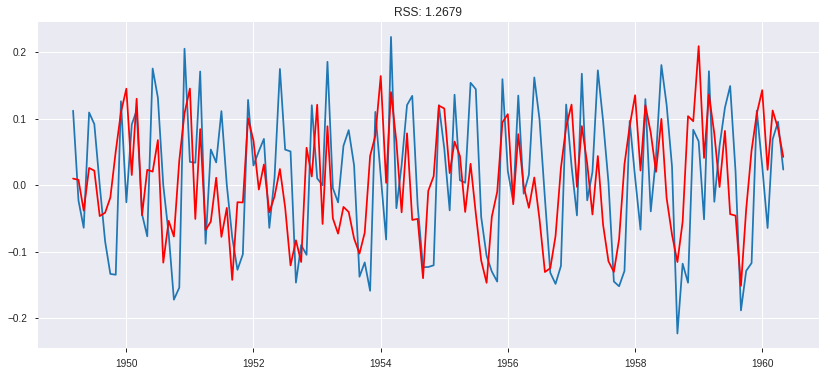

In [50]:
from statsmodels.tsa.arima_model import ARMA

# we use the ARMA model setting zero order for the AR model.
model_MA = ARMA(train, order=(0, 2))
results_MA = model_MA.fit()

plt.plot(train)
fittedvalues = pd.Series(results_MA.fittedvalues, index=train.index)
plt.plot(fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((fittedvalues - train)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);
print("Model Lag: %s" % results_MA.k_ma)
print("Model Coefficients: \n%s" % results_MA.params)

As we see the RSS is higher than in the previous model.

### Autoregressive Moving Average (ARMA)

ARMA forecasts the next step as a linear function of both the observations and the residual errors at prior time steps. Basically it is combining the Autoregression and the Moving Average models. As such, we need to specify both the order of the AR(p) and the MA(q) models resulting in the ARMA(p, q) and we can use it to create AR or MA models just by setting the corresponding order to zero.

Model Lag: 2
Model Coefficients:
 const               0.010069
ar.L1.Passengers    0.176427
ar.L2.Passengers    0.260169
ma.L1.Passengers   -0.186331
ma.L2.Passengers   -0.813669
dtype: float64


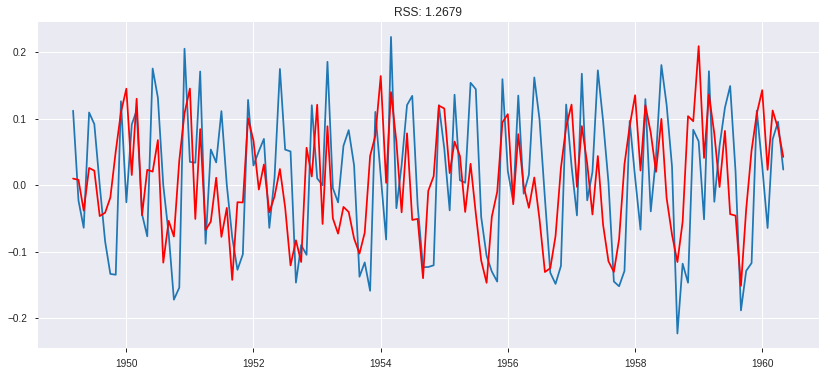

In [52]:
model_ARMA = ARMA(train, order=(2, 2))
results_ARMA = model_ARMA.fit()

plt.plot(train)
fittedvalues = pd.Series(results_MA.fittedvalues, index=train.index)
plt.plot(fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((fittedvalues - train)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);
print("Model Lag: %s" % results_ARMA.k_ma)
print("Model Coefficients:\n %s" % results_ARMA.params)

### Autoregressive Integrated Moving Average (ARIMA)

ARIMA stands for **Auto-Regressive Integrated Moving Averages** and it models the next step as a linear function of the differenced observations and residual errors at prior time steps. The ARIMA forecasting for a stationary TS is nothing but a linear equation. The predictors depend on the parameters p,d,q. The orders of the different parameters determine the model **ARIMA(p, d, q)**:
* Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
* Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [38]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [39]:
lag_acf = acf(ps_log_diff, nlags=20)
lag_pacf = pacf(ps_log_diff, nlags=20, method='ols')

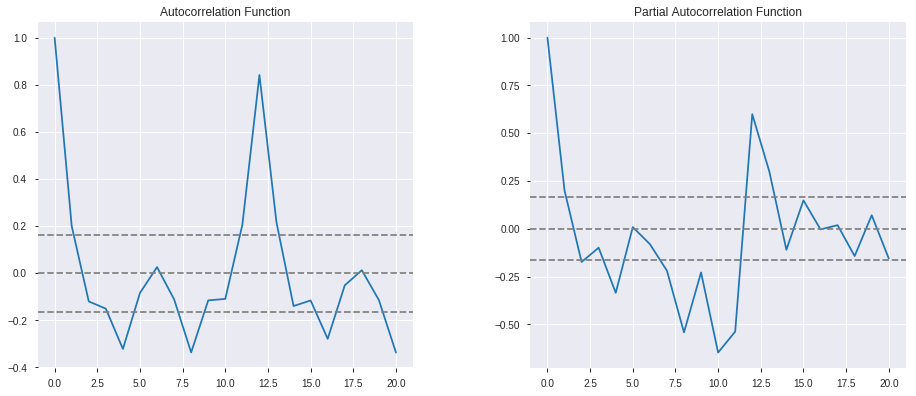

In [40]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ps_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ps_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ps_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ps_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout();fig = plt.gcf(); fig.set_size_inches(14, 6);

The two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

* p: The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
* q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now let's make 3 different ARIMA models considering individual as well as combined effects. We will report as well the RSS for each (here RSS is for the values of residuals and not actual series).

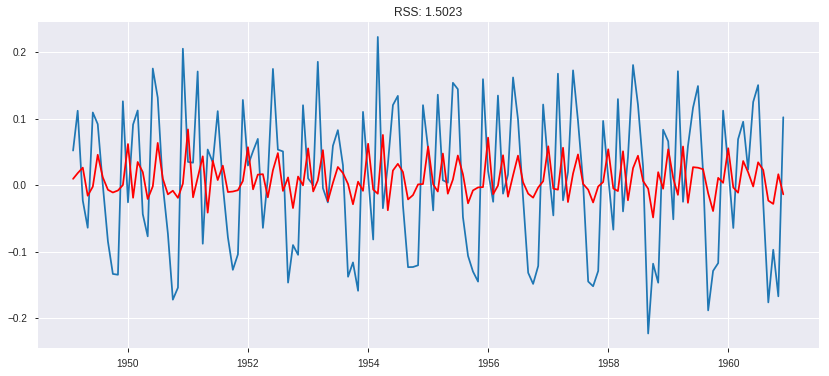

In [41]:
from statsmodels.tsa.arima_model import ARIMA

# AR MODEL. Using ps_log and d=1 to do the differentiation in the model
model = ARIMA(ps_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ps_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ps_log_diff)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);

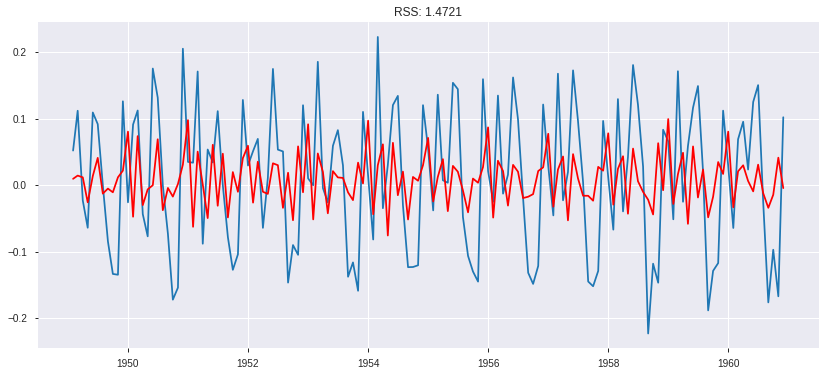

In [42]:
# MA MODEL
model = ARIMA(ps_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ps_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ps_log_diff)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);

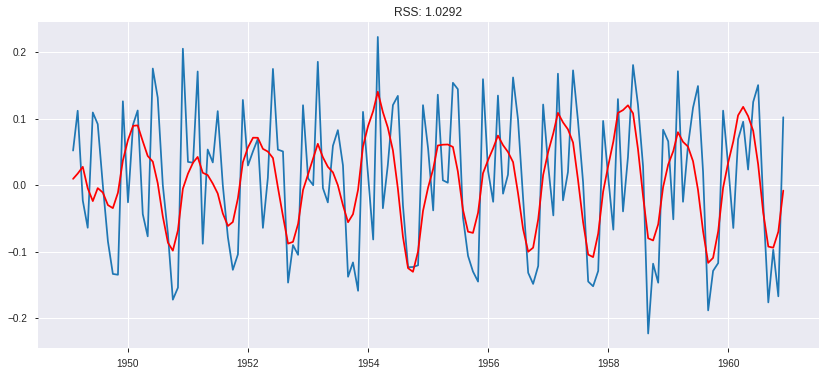

In [43]:
# Combined MODEL
model = ARIMA(ps_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ps_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ps_log_diff)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);

As we observe AR and MA models have almost the same RSS but combined is significantly better. Now the last step, taking these values back to the original scale for which we scale the combined model back to the original values and see how well it performs. First step would be to store the predicted results as a separate series and observe it.

Notice that these start from ‘1949-02-01’ and not the first month. This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from.

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
Freq: MS, dtype: float64

The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
Freq: MS, dtype: float64

Next we’ve to add them to base number. For this let's create a series with all values as base number and add the differences to it. This can be done as:

In [46]:
predictions_ARIMA_log = pd.Series(ps_log.iloc[0], index=ps_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
Freq: MS, dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

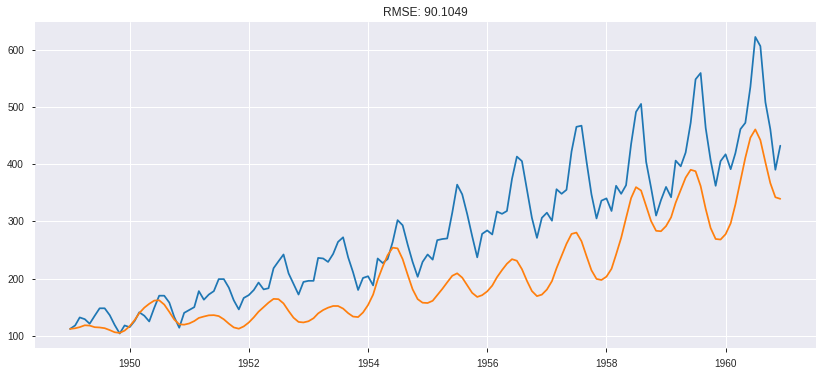

In [47]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ps)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ps)**2)/len(ps)))
fig = plt.gcf(); fig.set_size_inches(14, 6);

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In this model the next step in the sequence is a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation in the SARIMA model specifyes the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). As what we saw in the ARIMA model, a SARIMA model enables to develop AR, MA, ARMA and ARIMA models.


Optimization terminated successfully.
         Current function value: -1.296076
         Iterations: 14
         Function evaluations: 1601
Model Coefficients: 
ar.L1      0.985919
ar.L2     -0.966305
ma.L1     -1.161970
ma.L2      0.954712
ar.S.L2    1.009501
ar.S.L4   -0.991871
ma.S.L2   -1.142939
ma.S.L4    0.999718
sigma2     0.003769
dtype: float64

SARIMAX mle_retvals:
{'converged': True,
 'direc': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.56046662e-03,  2.67726426e-01,  7.56152424e-02,
         1.94003876e-01,  2.22525411e-03, -3.87915625e-02,
         1.23890485e-02, -3.41193855e-01, -1.02712897e-03],
       [-5.61996695e-02,  2.60957722e-01, -1.89765193e-01,
         2.83364490e-01, -6.41488297e-03,  1.47830618e+00,
        -1.64102215e-02,  6.53924362e-01, -4.53134745e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00

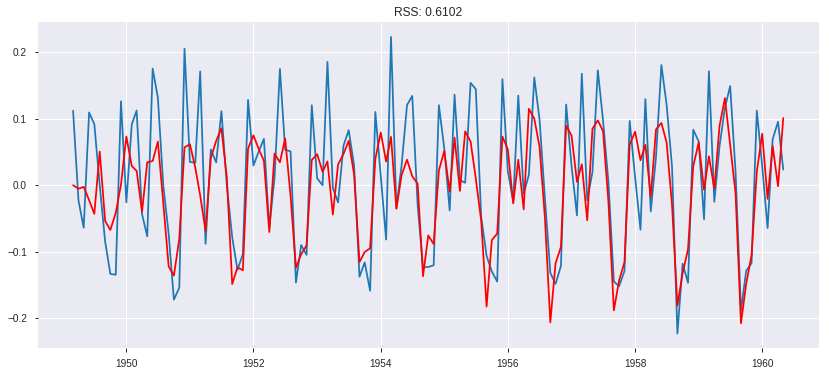

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMAX = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 0, 2, 2))
# we use powell instead of nm to avoid convergence issues
results_SARIMAX = model_SARIMAX.fit(maxiter=200, method='powell')

plt.plot(train)
fittedvalues = pd.Series(results_SARIMAX.fittedvalues, index=train.index)
plt.plot(fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((fittedvalues - train)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);
print("Model Coefficients: \n%s" % results_SARIMAX.params)
print("\nSARIMAX mle_retvals:")
pp(results_SARIMAX.mle_retvals)

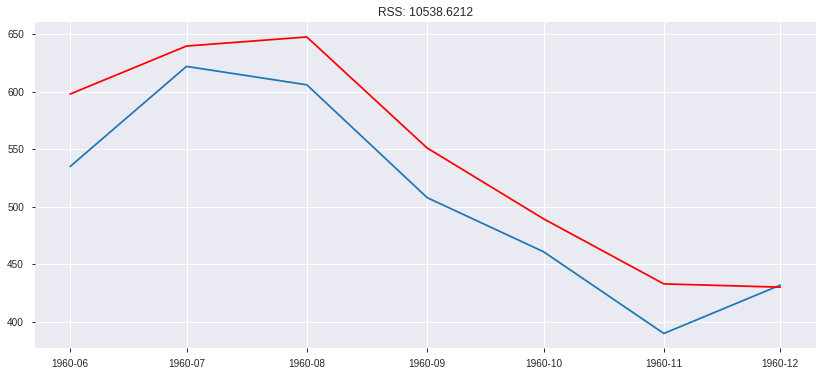

In [57]:
predictions = results_SARIMAX.predict(train.shape[0], train.shape[0] + 6)

pred = pd.Series(ps_log['1960-06-01'], index=ps_log.index[-7:])
pred = pred.add(predictions.cumsum(), fill_value=0).apply(exp)

plt.plot(passengers_test)
plt.plot(pred, color='red')
plt.title('RSS: %.4f'% sum((pred.values - passengers_test['Passengers'].values)**2))
fig = plt.gcf(); fig.set_size_inches(14, 6);

### Vector Autoregression (VAR)
The **VAR** method is the generalization of AR to multiple parallel time series (ex. multivariate time series).     This method models the next step in each time series using an AR model. We refer to this model as VAR(p).

The method is suitable for multivariate time series without trend and seasonal components.

In [58]:
from statsmodels.tsa.vector_ar.var_model import VAR


### Vector Autoregression Moving-Average (VARMA)
**VARMA** models the next step in each time series using the ARMA model. It is the generalization of ARMA to multiple parallel time series (ex. multivariate time series).

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to a VARMA function, e.g. VARMA(p, q). A VARMA model can also be used to develop VAR or VMA models.

The method is suitable for multivariate time series without trend and seasonal components.

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

model_VARMAX = VARMAX(test, order=(1, 1))

### Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
**VARMAX** is an extension of the VARMA model that also includes the modeling of exogenous variables. It is a multivariate version of the ARMAX method.

Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series. The primary series(es) are referred to as endogenous data to contrast it from the exogenous sequence(s). The observations for exogenous variables are included in the model directly at each time step and are not modeled in the same way as the primary endogenous sequence (e.g. as an AR, MA, etc. process).

The VARMAX method can also be used to model the subsumed models with exogenous variables, such as VARX and VMAX.

The method is suitable for multivariate time series without trend and seasonal components with exogenous variables.

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

model_VARMAX = VARMAX(test, exog=data_exog, order=(1, 1))
model_VARMAX.forecast(exog=data_exog2)

### Simple Exponential Smoothing (SES)
**SES** models the next time step as an exponentially weighted linear function of observations at prior time steps.

The method is suitable for univariate time series without trend and seasonal components.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_SES = SimpleExpSmoothing(test)

### Holt Winter’s Exponential Smoothing (HWES)
**HWES** also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.

The method is suitable for univariate time series with trend and/or seasonal components.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_HWES = ExponentialSmoothing(test)